# <img src="./resources/GA.png" width="25" height="25" />   <span style="color:Purple">Project 5 :  Food Insecurity Regression Study</span> 
---
## <span style="color:Green">Preprocessing / Modeling</span>      

#### Alec Edgecliffe-Johnson, Ryan McDonald, Andrew Roberts, Ira Seidman - General Assembly 



---

### Notebook Contents:

- [Reading the Data](#intro)
- [Modeling](#modeling)
    - [Production Model, LinReg](#prod)
         - [Extended Analysis](#analysis)
    - [Model #2, KNN](#second)
    - [Model #3, Decision Tree](#third)
    - [Model #4, PolyFeat, LinReg](#fourth)
    - [Model #5, ADA Boost](#fifth)
    - [Model #6, SVM](#sixth)
    - [Model #7, TensorFlow NN](#seventh)
    - [Model #8, RandomForest](#eigth)
    - [Model #9, PCA, LinRe](#ninth)


**Imports**

In [1]:
import pandas as pd
import numpy as np

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns

# SciKit Learn Processing/ Modeling Imports
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA

# Tensor Flow, Keras NN
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.utils import plot_model

<a id='intro'></a>

## 1. Read the Data
Read in data for each of the different imputation files - mean, median, mode, knn, lr, and rf

In [2]:
df_mean = pd.read_csv('cleaned_dataframes/df_m_mean.csv')
df_median = pd.read_csv('cleaned_dataframes/df_m_median.csv')
df_mode = pd.read_csv('cleaned_dataframes/df_m_mode.csv')
df_knn = pd.read_csv('cleaned_dataframes/df_m_knn.csv')
df_lr = pd.read_csv('cleaned_dataframes/df_m_lr.csv')
df_rf = pd.read_csv('cleaned_dataframes/df_m_rf.csv')

<a id='modeling'></a>
## Modeling Pre-work

**Setting X, y and Train-Test-Split for each imputation**

In [3]:
features_to_drop = ['ch_fi_rate_18', 'fi_rate_18', 'cpm_18', 'state_abr', 'state_name', 'fips', 'county']
dummified_features_to_drop = ['ch_fi_rate_18', 'fi_rate_18', 'cpm_18',  'fips']

# Also drop all the dummy variables from the 'state_abr', 'state_name', and 'county' columns in df_knn, df_lr, and df_rf 
for col in df_lr.columns:
    #print(col)
    if (col.startswith("state_abr") or col.startswith("state_name") or col.startswith("county")):
        dummified_features_to_drop.append(col)

# Set X and y for each imputation
X_mean, X_median, X_mode, X_knn, X_lr, X_rf = df_mean.drop(features_to_drop, axis = 1), df_median.drop(features_to_drop, axis = 1), df_mode.drop(features_to_drop, axis = 1), df_knn.drop(dummified_features_to_drop, axis = 1), df_lr.drop(dummified_features_to_drop, axis = 1), df_rf.drop(dummified_features_to_drop, axis = 1)
y_mean, y_median, y_mode, y_knn, y_lr, y_rf = df_mean['fi_rate_18'], df_median['fi_rate_18'], df_mode['fi_rate_18'], df_knn['fi_rate_18'], df_lr['fi_rate_18'], df_rf['fi_rate_18']

# Train-test splits
X_train_mean, X_test_mean, y_train_mean, y_test_mean = train_test_split(X_mean, y_mean, random_state = 1)
X_train_median, X_test_median, y_train_median, y_test_median = train_test_split(X_median, y_median, random_state = 1)
X_train_mode, X_test_mode, y_train_mode, y_test_mode = train_test_split(X_mode, y_mode, random_state = 1)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y_knn, random_state = 1)
X_train_lr, X_test_lr, y_train_lr, y_test_lr = train_test_split(X_lr, y_lr, random_state = 1)
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, random_state = 1)

In [4]:
# Scale data for each imptation
ss = StandardScaler()

Z_train_mean, Z_train_median, Z_train_mode, Z_train_knn, Z_train_lr, Z_train_rf = ss.fit_transform(X_train_mean), ss.fit_transform(X_train_median), ss.fit_transform(X_train_mode), ss.fit_transform(X_train_knn), ss.fit_transform(X_train_lr), ss.fit_transform(X_train_rf)
Z_test_mean, Z_test_median, Z_test_mode, Z_test_knn, Z_test_lr, Z_test_rf = ss.transform(X_test_mean), ss.transform(X_test_median), ss.transform(X_test_mode), ss.transform(X_test_knn), ss.transform(X_test_lr), ss.transform(X_test_rf)

y_trains = [y_mean, y_median, y_mode, y_knn, y_lr, y_rf]
Z_trains = [Z_train_mean, Z_train_median, Z_train_mode, Z_train_knn, Z_train_lr, Z_train_rf]

<a id='prod'></a>
### Model 1: Production Model

**Linear Regression**

In [5]:
LinearRegression().get_params().keys()

dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize'])

In [6]:
# Pipeline and gridsearch
pipe_lr = Pipeline([
    ('lr', LinearRegression())
])

# Gridsearch over the same parameters for all imputation pipes
pipe_ln_params = { 'lr__fit_intercept': [False, True],
                  'lr__copy_X': [False, True],
                  'lr__normalize': [False, True]
}

pipe_lr_mean, pipe_lr_median, pipe_lr_mode, pipe_lr_knn, pipe_lr_lr, pipe_lr_rf = pipe_lr.fit(Z_train_mean, y_train_mean), pipe_lr.fit(Z_train_median, y_train_median), pipe_lr.fit(Z_train_mode, y_train_mode), pipe_lr.fit(Z_train_knn, y_train_knn), pipe_lr.fit(Z_train_lr, y_train_lr), pipe_lr.fit(Z_train_rf, y_train_rf)


#Gridsearch on pipes for different imputations
gs_lr_mean = GridSearchCV(pipe_lr_mean,
                     param_grid = pipe_ln_params,
                     cv = 5)
gs_lr_median = GridSearchCV(pipe_lr_median,
                     param_grid = pipe_ln_params,
                     cv = 5)
gs_lr_mode = GridSearchCV(pipe_lr_mode,
                     param_grid = pipe_ln_params,
                     cv = 5)
gs_lr_knn = GridSearchCV(pipe_lr_knn,
                     param_grid = pipe_ln_params,
                     cv = 5)
gs_lr_lr = GridSearchCV(pipe_lr_lr,
                     param_grid = pipe_ln_params,
                     cv = 5)
gs_lr_rf = GridSearchCV(pipe_lr_rf,
                     param_grid = pipe_ln_params,
                     cv = 5)

gs_lr_mean.fit(Z_train_mean, y_train_mean), gs_lr_median.fit(Z_train_median, y_train_median), gs_lr_mode.fit(Z_train_mode, y_train_mode), gs_lr_knn.fit(Z_train_knn, y_train_knn), gs_lr_lr.fit(Z_train_lr, y_train_lr), gs_lr_rf.fit(Z_train_rf, y_train_rf)

# Return best scores and params for cross-validated pipes
lr_pipes = {'gs_lr_mean': [gs_lr_mean.best_score_, gs_lr_mean.best_params_],
            'gs_lr_median': [gs_lr_median.best_score_, gs_lr_median.best_params_],
            'gs_lr_mode': [gs_lr_mode.best_score_, gs_lr_mode.best_params_],
            'gs_lr_knn': [gs_lr_knn.best_score_, gs_lr_knn.best_params_],
            'gs_lr_lr': [gs_lr_lr.best_score_, gs_lr_lr.best_params_],
            'gs_lr_rf': [gs_lr_rf.best_score_, gs_lr_rf.best_params_]
           }

gs_lr_results = pd.DataFrame(lr_pipes)
gs_lr_results.head()

,gs_lr_mean,gs_lr_median,gs_lr_mode,gs_lr_knn,gs_lr_lr,gs_lr_rf
0,0.932081,0.932271,0.931995,0.935029,-474.216,0.935189
1,"{'lr__copy_X': False, 'lr__fit_intercept': Tru...","{'lr__copy_X': False, 'lr__fit_intercept': Tru...","{'lr__copy_X': False, 'lr__fit_intercept': Tru...","{'lr__copy_X': False, 'lr__fit_intercept': Tru...","{'lr__copy_X': False, 'lr__fit_intercept': Tru...","{'lr__copy_X': False, 'lr__fit_intercept': Tru..."


In [7]:
lr_mean_preds_train, lr_median_preds_train, lr_mode_preds_train, lr_knn_preds_train, lr_lr_preds_train, lr_rf_preds_train = gs_lr_mean.predict(Z_train_mean), gs_lr_median.predict(Z_train_median), gs_lr_mode.predict(Z_train_mode), gs_lr_knn.predict(Z_train_knn), gs_lr_lr.predict(Z_train_lr), gs_lr_rf.predict(Z_train_rf)
lr_mean_preds_test, lr_median_preds_test, lr_mode_preds_test, lr_knn_preds_test, lr_lr_preds_test, lr_rf_preds_test = gs_lr_mean.predict(Z_test_mean), gs_lr_median.predict(Z_test_median), gs_lr_mode.predict(Z_test_mode), gs_lr_knn.predict(Z_test_knn), gs_lr_lr.predict(Z_test_lr), gs_lr_rf.predict(Z_test_rf)

# Return best scores and params for predictions based off of training data
lr_mse_results = {'gs_lr_mean training score: ' : [mean_squared_error(y_train_mean, lr_mean_preds_train, squared = False), mean_squared_error(y_test_mean, lr_mean_preds_test, squared = False), gs_lr_mean.score(Z_train_rf, y_train_rf), gs_lr_mean.score(Z_test_rf, y_test_rf)],
                   'gs_lr_median training score: ' : [mean_squared_error(y_train_median, lr_median_preds_train, squared = False), mean_squared_error(y_test_median, lr_median_preds_test, squared = False), gs_lr_median.score(Z_train_rf, y_train_rf), gs_lr_median.score(Z_test_rf, y_test_rf)],
                   'gs_lr_mode training score: ' : [mean_squared_error(y_train_mode, lr_mode_preds_train, squared = False), mean_squared_error(y_test_mode, lr_mode_preds_test, squared = False), gs_lr_mode.score(Z_train_rf, y_train_rf), gs_lr_mode.score(Z_test_rf, y_test_rf)],
                   'gs_lr_knn training score: ' : [mean_squared_error(y_train_knn, lr_knn_preds_train, squared = False), mean_squared_error(y_test_knn, lr_knn_preds_test, squared = False), gs_lr_knn.score(Z_train_rf, y_train_rf), gs_lr_knn.score(Z_test_rf, y_test_rf)],
                   'gs_lr_lr training score: ' : [mean_squared_error(y_train_lr, lr_lr_preds_train, squared = False), mean_squared_error(y_test_lr, lr_lr_preds_test, squared = False), gs_lr_lr.score(Z_train_rf, y_train_rf), gs_lr_lr.score(Z_test_rf, y_test_rf)],
                   'gs_lr_rf training score: ' : [mean_squared_error(y_train_rf, lr_rf_preds_train, squared = False), mean_squared_error(y_test_rf, lr_rf_preds_test, squared = False), gs_lr_rf.score(Z_train_rf, y_train_rf), gs_lr_rf.score(Z_test_rf, y_test_rf)]
                  }

lr_mse_results = pd.DataFrame(lr_mse_results, index = ['Training RMSE', 'Testing RMSE', 'Training R2', 'Testing R2']).T
lr_mse_results

,Training RMSE,Testing RMSE,Training R2,Testing R2
gs_lr_mean training score:,0.944634,0.944203,0.940169,0.934663
gs_lr_median training score:,3.718488,0.940585,0.940152,0.934755
gs_lr_mode training score:,0.945299,0.951658,0.939697,0.934314
gs_lr_knn training score:,0.925629,0.946216,0.940283,0.935370
gs_lr_lr training score:,3.718518,20307.330799,-30405.095115,-32576.614223
gs_lr_rf training score:,0.925988,0.933373,0.940360,0.935316


In [8]:
# Reinstantiate pipe_lr with gridsearched parameters
pipe_lr = Pipeline([
    ('lr', LinearRegression(copy_X = False, fit_intercept = True, normalize = False))
])
pipe_lr = pipe_lr.fit(Z_train_mean, y_train_mean) 

# Show ten strongest features for best testing model - random forest imputation
coefs_lr = pipe_lr.named_steps['lr'].coef_.flatten()
feature_names_dummified = list(X_train_rf.columns) #list of features to use when outputting feature weights

model_zip = zip(feature_names_dummified, coefs_lr)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
44,percent_disabled,0.844686
16,percent_children_in_poverty,0.564253
5,percent_fair_or_poor_health,0.367634
28,percent_severe_housing_cost_burden,0.330053
39,percent_below_poverty,0.229229
18,percent_single_parent_households_CHR,0.174989
20,percent_severe_housing_problems,0.174969
17,num_households_CHR,0.157639
6,average_number_of_mentally_unhealthy_days,0.148209
40,percent_unemployed_CDC,0.146774


The best model fit was the linear regression using the random forest imputation data. Below are all the additional models fit, but none beat a testing RMSE of .9334 that weren't tremendously computationally intensive. This model may be slightly underfit, but not enough to try and introduce more variance with more data/columns 

<a id='second'></a>
### Model 2: KNN

In [9]:
KNeighborsRegressor().get_params().keys()

dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])

In [10]:
# Pipeline and gridsearch
pipe_knn = Pipeline([
    ('knn', KNeighborsRegressor())
])

pipe_knn_params = {'knn__n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
                  }

pipe_knn.fit(Z_train_rf, y_train_rf)

gs_knn = GridSearchCV(pipe_knn, 
                        param_grid = pipe_knn_params, 
                        cv = 5)

gs_knn.fit(Z_train_rf, y_train_rf);

In [11]:
print(f'Best score: {gs_knn.best_score_}')
print(f'Best parameters: {gs_knn.best_params_}')

Best score: 0.8564094905787188
Best parameters: {'knn__n_neighbors': 5}


In [12]:
knn_preds_train = gs_knn.predict(Z_train_rf)
knn_preds_test = gs_knn.predict(Z_test_rf)

print(f'Knn Training RMSE: {mean_squared_error(y_train_rf, knn_preds_train, squared = False)}')
print(f'Knn Testing RMSE: {mean_squared_error(y_test_rf, knn_preds_test, squared = False)}')
print(f'Training R2: {pipe_knn.score(Z_train_rf, y_train_rf)}')
print(f'Testing R2: {pipe_knn.score(Z_test_rf, y_test_rf)}')

Knn Training RMSE: 1.1507743538974573
Knn Testing RMSE: 1.471999376903773
Training R2: 0.9078905752959054
Testing R2: 0.8391212017356469


**Quick Analysis**

RMSE does not beat linear regression for any value of k. This model could be better fit, but it is not close enough to production model to attempt

<a id='third'></a>
### Model 3: Decision Tree

In [13]:
DecisionTreeRegressor().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

In [14]:
DecisionTreeRegressor().get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [15]:
# Pipeline and gridsearch
pipe_dt = Pipeline([
    ('dt', DecisionTreeRegressor())
])

pipe_dt_params = {'dt__max_depth': [5, 10, None], 
                  'dt__max_features': ['auto', 'log2'], 
                  'dt__max_depth': [2,4,6,8,10,12]
                 }

pipe_dt.fit(Z_train_rf, y_train_rf)
gs_dt = GridSearchCV(pipe_dt, 
                     param_grid = pipe_dt_params,
                     cv = 5)

gs_dt.fit(Z_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('dt', DecisionTreeRegressor())]),
             param_grid={'dt__max_depth': [2, 4, 6, 8, 10, 12],
                         'dt__max_features': ['auto', 'log2']})

In [16]:
print(f'Best score: {gs_dt.best_score_}')
print(f'Best parameters: {gs_dt.best_params_}')

Best score: 0.8003797736561346
Best parameters: {'dt__max_depth': 6, 'dt__max_features': 'auto'}


In [17]:
dt_preds_train = gs_dt.predict(Z_train_rf)
dt_preds_test = gs_dt.predict(Z_test_rf)

print(f'Dt training RMSE: {mean_squared_error(y_train_rf, knn_preds_train, squared = False)}')
print(f'Dt testing RMSE: {mean_squared_error(y_test_rf, knn_preds_test, squared = False)}')
print(f'Dt training R2: {pipe_dt.score(Z_train_rf, y_train_rf)}')
print(f'Dt testing R2: {pipe_dt.score(Z_test_rf, y_test_rf)}')

Dt training RMSE: 1.1507743538974573
Dt testing RMSE: 1.471999376903773
Dt training R2: 1.0
Dt testing R2: 0.7687885827225913


**Quick Analysis**

RMSE does not beat linear regression for any combination of hyperparameters. This model is very overfit, but it is not close enough to production model to attempt

<a id='fourth'></a>
### Model 4: PolynomialFeatures with StandardScalar and Linear Regression

In [18]:
poly_features = ['percent_children_in_poverty', 'percent_below_poverty', 'percent_fair_or_poor_health',
                 'pct_overall_pov_19','percentile_rank_social_vulnerability']

X_rf = df_rf[poly_features]
y_rf = df_rf['fi_rate_18']

X_train, X_test, y_train, y_test = train_test_split(X_rf,
                                                    y_rf,
                                                    random_state = 1)
pf = PolynomialFeatures(degree = 2)
X_train_pf = pf.fit_transform(X_train)
X_test_pf = pf.transform(X_test)

In [19]:
LinearRegression().get_params().keys(), PolynomialFeatures().get_params().keys()

(dict_keys(['copy_X', 'fit_intercept', 'n_jobs', 'normalize']),
 dict_keys(['degree', 'include_bias', 'interaction_only', 'order']))

In [20]:
# Pipeline and gridsearch
pipe_poly_lr = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression()),
])

pipe_poly_lr_params = {'lr__normalize': [True, False],
                       'lr__fit_intercept': [True, False]
                  }

pipe_poly_lr.fit(X_train_pf, y_train)
gs_poly_lr = GridSearchCV(pipe_poly_lr, 
                        param_grid = pipe_poly_lr_params, 
                        cv = 5)

gs_poly_lr.fit(X_train_pf, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('lr', LinearRegression())]),
             param_grid={'lr__fit_intercept': [True, False],
                         'lr__normalize': [True, False]})

In [21]:
print(f'Best score: {gs_poly_lr.best_score_}')
print(f'Best parameters: {gs_poly_lr.best_params_}')

Best score: 0.8074070574459841
Best parameters: {'lr__fit_intercept': True, 'lr__normalize': True}


In [22]:
# Reinstantiate pipe_poly_lr with gridsearched parameters
pipe_poly_lr = Pipeline([
    ('ss', StandardScaler()),
    ('lr', LinearRegression(fit_intercept = True, normalize = True))
])
pipe_poly_lr = pipe_lr.fit(Z_train_mean, y_train_mean) 

lr_poly_preds_train = gs_poly_lr.predict(X_train_pf)
lr_poly_preds_test = gs_poly_lr.predict(X_test_pf)

print(f'Poly lr Training RMSE: {mean_squared_error(y_train, lr_poly_preds_train, squared = False)}')
print(f'Poly lr Testing RMSE: {mean_squared_error(y_test, lr_poly_preds_test, squared = False)}')
print(f'Poly lr Training R2: {gs_poly_lr.score(X_train_pf, y_train)}')
print(f'Poly lr Testing R2: {gs_poly_lr.score(X_test_pf, y_test)}')

Poly lr Training RMSE: 1.6383377507745998
Poly lr Testing RMSE: 1.7307918859845965
Poly lr Training R2: 0.8133058982899347
Poly lr Testing R2: 0.7775802940495057


In [23]:
# Show ten strongest features for best testing model
coefs_lr_poly = pipe_poly_lr.named_steps['lr'].coef_.flatten()
model_zip = zip(feature_names_dummified, coefs_lr_poly)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
44,percent_disabled,0.844686
16,percent_children_in_poverty,0.564253
5,percent_fair_or_poor_health,0.367634
28,percent_severe_housing_cost_burden,0.330053
39,percent_below_poverty,0.229229
18,percent_single_parent_households_CHR,0.174989
20,percent_severe_housing_problems,0.174969
17,num_households_CHR,0.157639
6,average_number_of_mentally_unhealthy_days,0.148209
40,percent_unemployed_CDC,0.146774


**Will Lasso Improve our Score?**

In [24]:
lasso = LassoCV(max_iter = 15000 )
lasso.fit(X_train_pf, y_train)

LassoCV(max_iter=15000)

In [25]:
lasso_preds_train = lasso.predict(X_train_pf)
lasso_preds_test = lasso.predict(X_test_pf)

print(f'Lasso CV Training RMSE: {mean_squared_error(y_train, lasso_preds_train, squared = False)}')
print(f'Lasso CV Training RMSE: {mean_squared_error(y_test, lasso_preds_test, squared = False)}')
print(f"Lasso CV Training R2: {lasso.score(X_train_pf, y_train)}")
print(f"Lasso CV Testing R2: {lasso.score(X_test_pf, y_test)}")

Lasso CV Training RMSE: 1.8290381142003298
Lasso CV Training RMSE: 1.8633380988879227
Lasso CV Training R2: 0.7673145477251163
Lasso CV Testing R2: 0.7422095118120987


**Quick Analysis**

RMSE does not beat linear regression for any combination of hyperparameters with poly features. No improvement with lasso and though this model is very overfit, but it is not close enough to production model to attempt

<a id='fifth'></a>
### Model 5: ADA Boost

#### Setting Feature and Target Variables
**Scaling and Train-Test-Split**

In [26]:
# Set random seed
np.random.seed(42)
AdaBoostRegressor().get_params().keys()

dict_keys(['base_estimator', 'learning_rate', 'loss', 'n_estimators', 'random_state'])

In [27]:
# Pipeline and gridsearch
pipe_ada = Pipeline([
    ('ada', AdaBoostRegressor())
])

# Credit from subscription.packtub - https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781787286382/9/ch09lvl1sec95/tuning-an-adaboost-regressor
pipe_ada_params = {
    'ada__n_estimators': [100, 150, 200],
    'ada__learning_rate' : [1, 5, 10],
    'ada__loss' : ['linear', 'square', 'exponential']
}

pipe_ada.fit(Z_train_rf, y_train_rf)
gs_ada = GridSearchCV(pipe_ada, 
                        param_grid = pipe_ada_params, 
                        cv = 5)

gs_ada.fit(Z_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('ada', AdaBoostRegressor())]),
             param_grid={'ada__learning_rate': [1, 5, 10],
                         'ada__loss': ['linear', 'square', 'exponential'],
                         'ada__n_estimators': [100, 150, 200]})

In [28]:
print(f'Best score: {gs_ada.best_score_}')
print(f'Best parameters: {gs_ada.best_params_}')

Best score: 0.870771561472685
Best parameters: {'ada__learning_rate': 5, 'ada__loss': 'exponential', 'ada__n_estimators': 150}


In [29]:
# Reinstantiate pipe_ada with gridsearched parameters
pipe_ada = Pipeline([
    ('ada', AdaBoostRegressor(learning_rate = 5, loss = 'exponential', n_estimators = 150))
])
pipe_ada = pipe_ada.fit(Z_train_mean, y_train_mean)

ada_preds_train = gs_ada.predict(Z_train_rf)
ada_preds_test = gs_ada.predict(Z_test_rf)

print(f'AdaBoost Training RMSE: {mean_squared_error(y_train_rf, ada_preds_train, squared = False)}')
print(f'AdaBoost Testing RMSE: {mean_squared_error(y_test_rf, ada_preds_test, squared = False)}')
print(f'Training R2: {pipe_ada.score(Z_train_rf, y_train_rf)}')
print(f'Testing R2: {pipe_ada.score(Z_test_rf, y_test_rf)}')

AdaBoost Training RMSE: 1.2595210458115744
AdaBoost Testing RMSE: 1.455008375899492
Training R2: 0.8867648066871314
Testing R2: 0.8353152053922577


In [30]:
# Show ten strongest features for best testing model
coefs_ada = pipe_ada.named_steps['ada'].feature_importances_
model_zip = zip(feature_names_dummified, coefs_ada)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
39,percent_below_poverty,0.192617
16,percent_children_in_poverty,0.138434
6,average_number_of_mentally_unhealthy_days,0.078175
47,percentile_rank_social_vulnerability,0.075379
22,life_expectancy,0.063503
48,pct_overall_pov_19,0.061981
25,median_household_income,0.056408
44,percent_disabled,0.050518
40,percent_unemployed_CDC,0.036529
5,percent_fair_or_poor_health,0.034874


**Quick Analysis**

RMSE does not beat linear regression for any combination of hyperparameters. This model is again overfit, but it is not close enough to production model to attempt

<a id='sixth'></a>
### Model 6: Support Vector Machines

In [31]:
SVR().get_params().keys()

dict_keys(['C', 'cache_size', 'coef0', 'degree', 'epsilon', 'gamma', 'kernel', 'max_iter', 'shrinking', 'tol', 'verbose'])

In [32]:
# Pipeline and gridsearch
pipe_svr = Pipeline([
    ('svr', SVR(kernel = 'linear'))
])


pipe_svr_params = {
    'svr__C': [.01, .1, 1, 10, 100]
}


pipe_svr.fit(Z_train_rf, y_train_rf)
gs_svr = GridSearchCV(pipe_svr,
                      param_grid = pipe_svr_params,
                      cv = 5,
                      n_jobs = 4
)

gs_svr.fit(Z_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('svr', SVR(kernel='linear'))]),
             n_jobs=4, param_grid={'svr__C': [0.01, 0.1, 1, 10, 100]})

In [33]:
print(f'Best score: {gs_svr.best_score_}')
print(f'Best parameters: {gs_svr.best_params_}')

Best score: 0.9339332025592908
Best parameters: {'svr__C': 100}


In [34]:
# Reinstantiate pipe_svr with gridsearched parameters
pipe_svr = Pipeline([
    ('svr', SVR(kernel = 'linear', C = 100))
])
pipe_svr = pipe_svr.fit(Z_train_mean, y_train_mean)

svr_preds_train = gs_svr.predict(Z_train_rf)
svr_preds_test = gs_svr.predict(Z_test_rf)

print(f'SVR Training RMSE: {mean_squared_error(y_train, svr_preds_train, squared = False)}')
print(f'SVR Testing RMSE: {mean_squared_error(y_test, svr_preds_test, squared = False)}')
print(f'Training R2: {pipe_svr.score(Z_train_rf, y_train_rf)}')
print(f'Testing R2: {pipe_svr.score(Z_test_rf, y_test_rf)}')

SVR Training RMSE: 0.9364978536546309
SVR Testing RMSE: 0.9176818517578482
Training R2: 0.9388842943394556
Testing R2: 0.9369623422307928


In [35]:
# Show ten strongest features for best testing model - attribute error associated with coefficents. Cannot get coefficents, but since we are seeking accuracy over interpretability then that is OK.
coefs_svr = pipe_svr.named_steps['svr'].coef_.flatten()
model_zip = zip(feature_names_dummified, coefs_svr)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
44,percent_disabled,0.825926
16,percent_children_in_poverty,0.598516
5,percent_fair_or_poor_health,0.382689
45,percent_minorities,0.336838
34,percent_non_hispanic_white,0.335740
28,percent_severe_housing_cost_burden,0.286107
20,percent_severe_housing_problems,0.250383
18,percent_single_parent_households_CHR,0.220935
39,percent_below_poverty,0.186639
46,percent_limited_english_abilities,0.180408


**Quick Analysis**

RMSE does beat linear regression by about .015 on RMSE and is well fit, but given the computational requirements associated with this model it was not chosen as the production model

<a id='seventh'></a>
### Model 7: TensorFlow NN

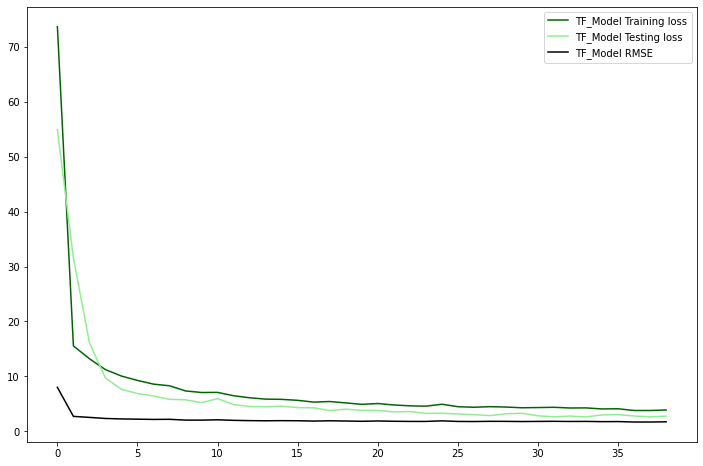

In [36]:
rmse = RootMeanSquaredError()

# Set up nn
model = Sequential()

model.add(Dense(64, input_shape = (Z_train_rf.shape[1],),
                activation = 'relu',
               ))

model.add(BatchNormalization()) # BatchNormalization layer added from Part 7

model.add(Dense(128, activation = 'relu',
                kernel_regularizer = l2(0.01)
               )) # Second hidden layer

model.add(Dropout(0.05)) # Dropout layer 5 % to 2nd layer

model.add(Dense(64, activation = 'relu', 
                kernel_regularizer = l2(0.1)
               )) # Third hidden layer

model.add(Dropout(0.20)) # Dropout layer 20 % to 3rd layer

# Add output layer

model.add(Dense(1, activation = None)) 

# Compile
model.compile(loss = 'mse', optimizer = 'adam', metrics= [rmse,'mse'])                                     

# Early_stop object
early_stop = EarlyStopping(patience = 5)

# Fit
results_es = model.fit(Z_train_rf, y_train_rf,
            validation_data = (Z_test_rf, y_test_rf),
            epochs = 50, 
            verbose = 0,
            callbacks = [early_stop])

# Visualize loss
train_loss = results_es.history['loss']
test_loss = results_es.history['val_loss']
train_rmse = results_es.history['root_mean_squared_error']

plt.figure(figsize = (12, 8))
plt.plot(train_loss, label = 'TF_Model Training loss', color = 'darkgreen')
plt.plot(test_loss, label = 'TF_Model Testing loss', color = 'lightgreen')
plt.plot(train_rmse, label = 'TF_Model RMSE', color = 'Black')

plt.legend()

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                3456      
_________________________________________________________________
batch_normalization (BatchNo (None, 64)                256       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

In [38]:
plot_model(model, show_layer_names = True, show_shapes = True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [39]:
results_es.history.keys()

dict_keys(['loss', 'root_mean_squared_error', 'mse', 'val_loss', 'val_root_mean_squared_error', 'val_mse'])

In [40]:
# TF Training RMSE
results_es.history['root_mean_squared_error'][-1]

1.7381765842437744

In [41]:
# TF Testing RMSE
results_es.history['val_root_mean_squared_error'][-1]

1.3746938705444336

**Quick Analysis**

RMSE does not beat linear regression for any combination of hyperparameters. This model is overfit, but it is not close enough to production model to attempt

<a id='eigth'></a>
### Model 8: Random Forest Regressor

In [42]:
# Pipeline and gridsearch
RandomForestRegressor().get_params().keys()
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor())
])
pipe_rf_params = {'rf__max_depth': [5, 10, None],
                 }
pipe_rf.fit(Z_train_rf, y_train_rf)
gs_rf = GridSearchCV(pipe_rf,
                     param_grid = pipe_rf_params,
                     cv = 5)

gs_rf.fit(Z_train_rf, y_train_rf)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('rf', RandomForestRegressor())]),
             param_grid={'rf__max_depth': [5, 10, None]})

In [43]:
print(f'Best score rf: {gs_rf.best_score_}')
print(f'Best parameters rf: {gs_rf.best_params_}')

Best score rf: 0.8961033322387486
Best parameters rf: {'rf__max_depth': None}


In [44]:
# Reinstantiate pipe_svr with gridsearched parameters
pipe_rf = Pipeline([
    ('rf', RandomForestRegressor(max_depth = None))
])
pipe_rf = pipe_rf.fit(Z_train_mean, y_train_mean)

rf_preds_train = gs_rf.predict(Z_train_rf)
rf_preds_test = gs_rf.predict(Z_test_rf)

print(f'Rf Training RMSE: {mean_squared_error(y_train_rf, rf_preds_train, squared = False)}')
print(f'Rf Testing RMSE: {mean_squared_error(y_test_rf, rf_preds_test, squared = False)}')
print(f'Rf Training R2: {pipe_rf.score(Z_train_rf, y_train_rf)}')
print(f'Rf Testing R2: {pipe_rf.score(Z_test_rf, y_test_rf)}')

Rf Training RMSE: 0.4520996141852997
Rf Testing RMSE: 1.249395872355865
Rf Training R2: 0.9844740072014287
Rf Testing R2: 0.883616383402859


In [45]:
# Show ten strongest features for best testing model
coefs_rf = pipe_rf.named_steps['rf'].feature_importances_
model_zip = zip(feature_names_dummified, coefs_rf)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
16,percent_children_in_poverty,0.489700
39,percent_below_poverty,0.126649
10,food_environment_index,0.078389
5,percent_fair_or_poor_health,0.051816
44,percent_disabled,0.038483
25,median_household_income,0.037391
48,pct_overall_pov_19,0.027897
22,life_expectancy,0.015378
6,average_number_of_mentally_unhealthy_days,0.015304
0,lat,0.010129


**Quick Analysis**

RMSE does not beat linear regression for any combination of hyperparameters. This model is very overfit, but it is not close enough to production model to attempt

<a id='ninth'></a>
### Model 9: PCA Pipeline w/ Lin Reg

In [46]:
pca = PCA()
pca.get_params().keys()

dict_keys(['copy', 'iterated_power', 'n_components', 'random_state', 'svd_solver', 'tol', 'whiten'])

In [47]:
# Pipeline and gridsearch
pipe_pca_lr = Pipeline([
    ('pca', PCA()),
    ('lr', LinearRegression()),
])
pipe_pca_lr_params = {'lr__normalize':[True, False],
                  'lr__fit_intercept':[True, False],
                  'pca__n_components':[5, 7, 10, 12, 15, 20, 30, 50],
                  'pca__random_state':[42, 2021],
                  'pca__tol':[0, 0.1, 1],
                  'pca__whiten':[True, False],
                  'pca__svd_solver':['auto','full', 'arpack','randomized'],
                  'pca__iterated_power': [0, 1, 2, 3]
                  }

pipe_pca_lr.fit(Z_train_rf, y_train_rf)
gs_pca_lr = GridSearchCV(pipe_pca_lr,
                     param_grid = pipe_pca_lr_params,
                     cv = 5)

gs_pca_lr.fit(Z_train_rf, y_train_rf)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA()),
                                       ('lr', LinearRegression())]),
             param_grid={'lr__fit_intercept': [True, False],
                         'lr__normalize': [True, False],
                         'pca__iterated_power': [0, 1, 2, 3],
                         'pca__n_components': [5, 7, 10, 12, 15, 20, 30, 50],
                         'pca__random_state': [42, 2021],
                         'pca__svd_solver': ['auto', 'full', 'arpack',
                                             'randomized'],
                         'pca__tol': [0, 0.1, 1],
                         'pca__whiten': [True, False]})

In [48]:
print(f'Best score rf: {gs_pca_lr.best_score_}')
print(f'Best parameters rf: {gs_pca_lr.best_params_}')

Best score rf: 0.9351391144793538
Best parameters rf: {'lr__fit_intercept': True, 'lr__normalize': True, 'pca__iterated_power': 1, 'pca__n_components': 50, 'pca__random_state': 2021, 'pca__svd_solver': 'randomized', 'pca__tol': 0, 'pca__whiten': True}


In [49]:
# Reinstantiate pipe_svr with gridsearched parameters
pipe_pca_lr = Pipeline([
    ('pca', PCA(iterated_power = 1, n_components = 50, random_state = 2021, svd_solver = 'randomized', tol = 0, whiten = True)),
    ('lr', LinearRegression(fit_intercept = True, normalize = True)),
])
pipe_pca_lr.fit(Z_train_rf, y_train_rf)

lr_pca_preds_train = gs_pca_lr.predict(Z_train_rf)
lr_pca_preds_test = gs_pca_lr.predict(Z_test_rf)

print(f'Lr with PCA Training RMSE: {mean_squared_error(y_train_rf, lr_pca_preds_train, squared = False)}')
print(f'Lr with Testing RMSE: {mean_squared_error(y_test_rf, lr_pca_preds_test, squared = False)}')
print(f'Lr with PCA Training R2: {pipe_pca_lr.score(Z_train_rf, y_train_rf)}')
print(f'Lr with with PCA Testing R2: {pipe_pca_lr.score(Z_test_rf, y_test_rf)}')

Lr with PCA Training RMSE: 0.9285481220245976
Lr with Testing RMSE: 0.9380487496890981
Lr with PCA Training R2: 0.9400302066313364
Lr with with PCA Testing R2: 0.9346667325002813


In [50]:
# Show ten strongest features for best testing model
coefs_pca_lr = pipe_pca_lr.named_steps['lr'].coef_.flatten()
model_zip = zip(feature_names_dummified, coefs_pca_lr)
model_zip_df = pd.DataFrame(model_zip, columns = ['features', 'coefficients'])
model_zip_df.sort_values(by = 'coefficients', ascending = False).head(10)

,features,coefficients
0,lat,3.354799
47,percentile_rank_social_vulnerability,0.616023
9,percent_adults_with_obesity,0.451246
4,population_density_per_sqmi,0.398362
43,percent_age_17_and_younger,0.388949
3,area_sqmi,0.388268
29,percent_black,0.281396
15,high_school_graduation_rate,0.254437
10,food_environment_index,0.240137
24,percent_limited_access_to_healthy_foods,0.233404


**Quick Analysis**

RMSE is very close to the linear regression for the best hyperparameters and is well-fit, but is not worth the computational resources to use or further refine